In [48]:
import pandas as pd
import numpy as np
from pandas_datareader import data, wb
import datetime

import sys
sys.path.append('../..')
from backtester import matlab, backtester
from backtester.analysis import *
from pandas.tseries.offsets import *

In [49]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


`%matplotlib` prevents importing * from pylab and numpy


In [50]:
#
# random time series
#
date = pd.date_range(start='2015-01', end='2015-05', freq='D')
price = np.random.randint(-100, 100, size=len(date))
df = pd.DataFrame(price, index=date, columns=['close'])
df = df.cumsum()

In [51]:
#
# Real ticker data
#
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime.now()

price_data = data.DataReader('SPY', 'yahoo', start, end)
adjclose_series = price_data['Adj Close']
adjclose_series.name = 'close'

df = pd.DataFrame(adjclose_series)

In [52]:
strategyname = 'strategy_180113'
d, info = matlab.loaddata('../../mat/'+strategyname+'.mat')

df = pd.DataFrame()
df['close'] = d.exo

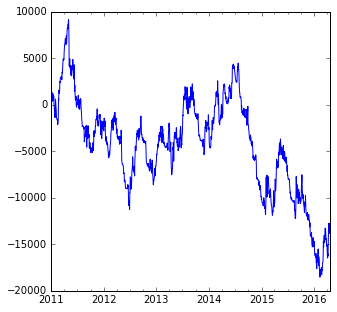

In [53]:
figsize(5,5)
d.exo.plot()

In [54]:
info

{'legs': 3,
 'margin': 4510,
 'name': 'CallSpread',
 'pcf': array([0, 0, 2], dtype=uint8),
 'pcfqty': array([ 1, -1,  0], dtype=int16),
 'tickincrement': 0.01,
 'tickvalue': 10,
 'underlying': 'CLE'}

## Renko calculation

## High/Low of renko bricks is only needed for visual representation

In [55]:
box_size = 100

box_start = 0
box_start_idx = None

box_end = 0
box_quantity = 0

temp_l = []

# Simple renko algorihtm


# 
for i in range(len(df)):
    if box_start == 0:
        box_start = df.close[i]

    else:
        box_start = box_start
        price_move = df.close[i] - box_start
        
        # First of all we need to set box size. 
        # Then calculate price movement. 
        # If price movement is more or equal than box size - renko bar(or bars) will be added
        
        if np.abs(price_move) >= box_size:
            
            # After we calculate box_quantity(price move divided by box size)
            # This number defines how much renko bars will be registred
            box_quantity = np.int32(np.floor(np.abs(price_move / box_size)))
            box_index = df.close.index[i]

            for b in range(int(box_quantity)):
            # Let say, index is 2015-01-01, box_start = 100, box_quantity = 3, box size = 10, price move > 0
            # So renko bar 1 will have next parameters - 
            # 1)index 2015-01-01
            # 2)open = 100
            # 3)close = 110(box_start + box_size)
            # 4)type = up
            
            # Next renko bar will have next parameters -
            # 1)index 2015-01-01
            # 2)open = 110(previous renko bar close)
            # 3)close = 120(open + box_size)
            # 4)type = up
            
            # And so on..
            
            # After all we adding renko bars dict to list and convert it to DF
            
                if price_move > 0:
                    if box_end == 0:
                        d = {'date': box_index, 'open': box_start, 'close': box_start + box_size, 'type': 'up'}
                        box_end = d['close']
                        temp_l.append(d)
                        
                    else:
                        d = {'date': box_index, 'open': box_end, 'close': box_end + box_size,
                            'type': 'up'}
                        
                        box_end = d['close']
                        temp_l.append(d)

                if price_move < 0:
                    if box_end == 0:
                        d = {'date': box_index, 'open': box_start, 'close': box_start - box_size, 'type': 'down'}
                        box_end = d['close']
                        temp_l.append(d)
                        
                    else:           
                        d = {'date': box_index, 'open': box_end, 'close': box_end - box_size, 
                             'type': 'down'}
                        
                        box_end = d['close']
                        temp_l.append(d)
                        
            box_start = df.close[i]
            
renko_df = pd.DataFrame(temp_l)

del temp_l

high_l = []
low_l = []
for i in range(len(renko_df)):
    if renko_df.close[i] > renko_df.open[i]:
        high_l.append(renko_df.close[i])
        low_l.append(renko_df.open[i])
        
    if renko_df.close[i] < renko_df.open[i]:
        high_l.append(renko_df.open[i])
        low_l.append(renko_df.close[i])
        
renko_df['low'] = low_l
renko_df['high'] = high_l

del low_l
del high_l

## Defining peaks and falls and their prices

In [56]:
# Peaks
renko_peak = ((renko_df.type == 'down') & (renko_df.type.shift(1) == 'down') 
          & (renko_df.type.shift(2) == 'up') & (renko_df.type.shift(3) == 'up'))

renko_df['peak'] = renko_peak

# Adding underlying_pick_price column
ul_peak_price = df.close[df.close.index.isin(renko_df[renko_df.peak.shift(-2) == True].date)]
ul_peak_price.name = 'underlying_peak_price'

renko_df = renko_df.join(ul_peak_price, on=['date'])
renko_df.underlying_peak_price = renko_df.underlying_peak_price.shift(2) #This needed for avoiding future reference problem

renko_df.loc[renko_df.peak == False, 'underlying_peak_price'] = np.NaN # Drop all values which available earlier than peak/fall occurs

renko_df['renko_peak_price'] = renko_df.close[renko_df.peak.shift(-2) == True]
renko_df.renko_peak_price = renko_df.renko_peak_price.shift(2) #This needed for avoiding future reference problem

In [57]:
# Falls
renko_fall = ((renko_df.type == 'up') & (renko_df.type.shift(1) == 'up') 
          & (renko_df.type.shift(2) == 'down') & (renko_df.type.shift(3) == 'down'))

renko_df['fall'] = renko_fall

# Adding underlying_fall_price column 
ul_fall_price = df.close[df.close.index.isin(renko_df[renko_df.fall.shift(-2) == True].date)]
ul_fall_price.name = 'underlying_fall_price'

renko_df = renko_df.join(ul_fall_price, on=['date'])
renko_df.underlying_fall_price = renko_df.underlying_fall_price.shift(2) #This needed for avoiding future reference problem

renko_df.loc[renko_df.fall == False, 'underlying_fall_price'] = np.NaN # Drop all values which available earlier than peak/fall occurs

renko_df['renko_fall_price'] = renko_df.close[renko_df.fall.shift(-2) == True]
renko_df.renko_fall_price = renko_df.renko_fall_price.shift(2) #This needed for avoiding future reference problem

In [67]:
renko_df.renko_peak_price = renko_df.renko_peak_price.fillna(method='ffill')
renko_df.renko_fall_price = renko_df.renko_fall_price.fillna(method='ffill')

## Flat and trend patterns

In [59]:
renko_flat = (((renko_df.type == 'up') & (renko_df.type.shift(1) == 'down') 
                & (renko_df.type.shift(2) == 'up') & (renko_df.type.shift(3) == 'down')) | 
              ((renko_df.type == 'down') & (renko_df.type.shift(1) == 'up') & (renko_df.type.shift(2) == 'down') 
             & (renko_df.type.shift(3) == 'up')))

renko_df['flat'] = renko_flat

renko_trend_up = ((renko_df.type == 'up') & (renko_df.type.shift(1) == 'up') & (renko_df.type.shift(2) == 'up'))
renko_trend_down = ((renko_df.type == 'down') & (renko_df.type.shift(1) == 'down') & (renko_df.type.shift(2) == 'down'))

renko_df['trend_up'] = renko_trend_up
renko_df['trend_down'] = renko_trend_down

## Small double top/bottom pattern

In [60]:
renko_small_double_top = ((renko_df.type == 'down') & (renko_df.type.shift(1) == 'down') & (renko_df.type.shift(2) == 'up')
                         & (renko_df.type.shift(3) == 'down') & (renko_df.type.shift(4) == 'up') & (renko_df.type.shift(5) == 'up'))

renko_df['small_double_top'] = renko_small_double_top

renko_small_double_bottom = ((renko_df.type == 'up') & (renko_df.type.shift(1) == 'up') & (renko_df.type.shift(2) == 'down')
                         & (renko_df.type.shift(3) == 'up') & (renko_df.type.shift(4) == 'down') & (renko_df.type.shift(5) == 'down'))

renko_df['small_double_bottom'] = renko_small_double_bottom

## Trend correction pattern( no.7 in renko patterns.pdf)

In [61]:
renko_up_trend_correction = ((renko_df.type == 'up') & (renko_df.type.shift(1) == 'up') & (renko_df.type.shift(2) == 'down')
                            & (renko_df.type.shift(3) == 'up') & (renko_df.type.shift(4) == 'up'))

renko_df['up_trend_correction'] = renko_up_trend_correction

renko_down_trend_correction = ((renko_df.type == 'down') & (renko_df.type.shift(1) == 'down') & (renko_df.type.shift(2) == 'up')
                            & (renko_df.type.shift(3) == 'down') & (renko_df.type.shift(4) == 'down'))

renko_df['down_trend_correction'] = renko_down_trend_correction

# Peak/fall prices combinations

### Defining peak/fall price direction relative to previous peak/fall price

In [62]:
renko_peak_df = renko_df[renko_df.peak == True]

renko_peak_price_move = np.array([None] * len(renko_peak_df.type))
#renko_peak_price_move = np.empty_like(renko_peak_df.type) # This code crashes the python...

for i in range(len(renko_peak_df)):
    if i > 0:
        if renko_peak_df.renko_peak_price.values[i] > renko_peak_df.renko_peak_price.values[i-1]: 
            renko_peak_price_move[i] = 'up'
            
        elif renko_peak_df.renko_peak_price.values[i] < renko_peak_df.renko_peak_price.values[i-1]:
            renko_peak_price_move[i] = 'down'
            
        elif renko_peak_df.renko_peak_price.values[i-1] == renko_peak_df.renko_peak_price.values[i]:
            renko_peak_price_move[i] = 'same'

renko_df = renko_df.join(pd.Series(renko_peak_price_move, index=renko_peak_df.index, name='renko_peak_price_move').replace([None],np.NaN))

del renko_peak_df

In [63]:
renko_fall_df = renko_df[renko_df.fall == True]

renko_fall_price_move = np.array([None] * len(renko_fall_df.type))

for i in range(len(renko_fall_df)):
    if i > 0:
        if renko_fall_df.renko_fall_price.values[i] > renko_fall_df.renko_fall_price.values[i-1]: 
            renko_fall_price_move[i] = 'up'
            
        elif renko_fall_df.renko_fall_price.values[i] < renko_fall_df.renko_fall_price.values[i-1]:
            renko_fall_price_move[i] = 'down'
            
        elif renko_fall_df.renko_fall_price.values[i-1] == renko_fall_df.renko_fall_price.values[i]:
            renko_fall_price_move[i] = 'same'

renko_df = renko_df.join(pd.Series(renko_fall_price_move, index=renko_fall_df.index, name='renko_fall_price_move').replace([None],np.NaN))

del renko_fall_df

## Patterns
#### Peak
#### Consecutive peak price movements count

In [64]:
renko_peak_price_move_ser = renko_df.renko_peak_price_move.dropna()
renko_peak_price_move_ser_prev = renko_df.renko_peak_price_move.dropna().shift(1)

up_move_count = []
up_move_counter = 0

down_move_count = []
down_move_counter = 0

same_move_count = []
same_move_counter = 0

for i in renko_peak_price_move_ser.index:
    
    if i > 0:
    # Consec Up peak price movements
        if (renko_peak_price_move_ser[i] == 'up') & (renko_peak_price_move_ser_prev[i] != 'up'):
            up_move_counter = 1
            up_move_count.append(up_move_counter)
            
        elif (renko_peak_price_move_ser[i] == 'up') & (renko_peak_price_move_ser_prev[i] == 'up'):
            up_move_counter += 1
            up_move_count.append(up_move_counter)
            
        elif (renko_peak_price_move_ser[i] != 'up') & (renko_peak_price_move_ser_prev[i] == 'up'):
            up_move_counter = 0
            up_move_count.append(up_move_counter)
            
        elif (renko_peak_price_move_ser[i] != 'up') & (renko_peak_price_move_ser_prev[i] != 'up'):
            up_move_counter = 0
            up_move_count.append(up_move_counter)
            
    # Consec down peak price movements  
        if (renko_peak_price_move_ser[i] == 'down') & (renko_peak_price_move_ser_prev[i] != 'down'):
            down_move_counter = 1
            down_move_count.append(down_move_counter)
            
        elif (renko_peak_price_move_ser[i] == 'down') & (renko_peak_price_move_ser_prev[i] == 'down'):
            down_move_counter += 1
            down_move_count.append(down_move_counter)
            
        elif (renko_peak_price_move_ser[i] != 'down') & (renko_peak_price_move_ser_prev[i] == 'down'):
            down_move_counter = 0
            down_move_count.append(down_move_counter)
            
        elif (renko_peak_price_move_ser[i] != 'down') & (renko_peak_price_move_ser_prev[i] != 'down'):
            down_move_counter = 0
            down_move_count.append(down_move_counter)
            
    # Consec same peak price movements
        if (renko_peak_price_move_ser[i] == 'same') & (renko_peak_price_move_ser_prev[i] != 'same'):
            same_move_counter = 1
            same_move_count.append(same_move_counter)
            
        elif (renko_peak_price_move_ser[i] == 'same') & (renko_peak_price_move_ser_prev[i] == 'same'):
            same_move_counter += 1
            same_move_count.append(same_move_counter)
            
        elif (renko_peak_price_move_ser[i] != 'same') & (renko_peak_price_move_ser_prev[i] == 'same'):
            same_move_counter = 0
            same_move_count.append(same_move_counter)
            
        elif (renko_peak_price_move_ser[i] != 'same') & (renko_peak_price_move_ser_prev[i] != 'same'):
            same_move_counter = 0
            same_move_count.append(same_move_counter)

renko_df['renko_peak_price_up_move_count'] = pd.Series(up_move_count, index=renko_peak_price_move_ser.index, 
                                                       name='renko_peak_price_up_move_count')
  
renko_df['renko_peak_price_down_move_count'] = pd.Series(down_move_count, index=renko_peak_price_move_ser.index, 
                                                         name='renko_peak_price_down_move_count')

renko_df['renko_peak_price_same_move_count'] = pd.Series(same_move_count, index=renko_peak_price_move_ser.index, 
                                                         name='renko_peak_price_same_move_count')

#### Fall
#### Consecutive peak price movements count

In [65]:
renko_fall_price_move_ser = renko_df.renko_fall_price_move.dropna()
renko_fall_price_move_ser_prev = renko_df.renko_fall_price_move.dropna().shift(1)

up_move_count = []
up_move_counter = 0

down_move_count = []
down_move_counter = 0

same_move_count = []
same_move_counter = 0

for i in renko_fall_price_move_ser.index:
    
    if i > 0:
    # Consec Up fall price movements
        if (renko_fall_price_move_ser[i] == 'up') & (renko_fall_price_move_ser_prev[i] != 'up'):
            up_move_counter = 1
            up_move_count.append(up_move_counter)
            
        elif (renko_fall_price_move_ser[i] == 'up') & (renko_fall_price_move_ser_prev[i] == 'up'):
            up_move_counter += 1
            up_move_count.append(up_move_counter)
            
        elif (renko_fall_price_move_ser[i] != 'up') & (renko_fall_price_move_ser_prev[i] == 'up'):
            up_move_counter = 0
            up_move_count.append(up_move_counter)
            
        elif (renko_fall_price_move_ser[i] != 'up') & (renko_fall_price_move_ser_prev[i] != 'up'):
            up_move_counter = 0
            up_move_count.append(up_move_counter)
            
    # Consec down fall price movements  
        if (renko_fall_price_move_ser[i] == 'down') & (renko_fall_price_move_ser_prev[i] != 'down'):
            down_move_counter = 1
            down_move_count.append(down_move_counter)
            
        elif (renko_fall_price_move_ser[i] == 'down') & (renko_fall_price_move_ser_prev[i] == 'down'):
            down_move_counter += 1
            down_move_count.append(down_move_counter)
            
        elif (renko_fall_price_move_ser[i] != 'down') & (renko_fall_price_move_ser_prev[i] == 'down'):
            down_move_counter = 0
            down_move_count.append(down_move_counter)
            
        elif (renko_fall_price_move_ser[i] != 'down') & (renko_fall_price_move_ser_prev[i] != 'down'):
            down_move_counter = 0
            down_move_count.append(down_move_counter)
            
    # Consec same fall price movements
        if (renko_fall_price_move_ser[i] == 'same') & (renko_fall_price_move_ser_prev[i] != 'same'):
            same_move_counter = 1
            same_move_count.append(same_move_counter)
            
        elif (renko_fall_price_move_ser[i] == 'same') & (renko_fall_price_move_ser_prev[i] == 'same'):
            same_move_counter += 1
            same_move_count.append(same_move_counter)
            
        elif (renko_fall_price_move_ser[i] != 'same') & (renko_fall_price_move_ser_prev[i] == 'same'):
            same_move_counter = 0
            same_move_count.append(same_move_counter)
            
        elif (renko_fall_price_move_ser[i] != 'same') & (renko_fall_price_move_ser_prev[i] != 'same'):
            same_move_counter = 0
            same_move_count.append(same_move_counter)

renko_df['renko_fall_price_up_move_count'] = pd.Series(up_move_count, index=renko_fall_price_move_ser.index, 
                                                       name='renko_fall_price_up_move_count')
  
renko_df['renko_fall_price_down_move_count'] = pd.Series(down_move_count, index=renko_fall_price_move_ser.index, 
                                                         name='renko_fall_price_down_move_count')

renko_df['renko_fall_price_same_move_count'] = pd.Series(same_move_count, index=renko_fall_price_move_ser.index, 
                                                         name='renko_fall_price_same_move_count')

In [66]:
renko_df

,close,date,open,type,low,high,peak,underlying_peak_price,renko_peak_price,fall,...,up_trend_correction,down_trend_correction,renko_peak_price_move,renko_fall_price_move,renko_peak_price_up_move_count,renko_peak_price_down_move_count,renko_peak_price_same_move_count,renko_fall_price_up_move_count,renko_fall_price_down_move_count,renko_fall_price_same_move_count
0,2000.0,2011-01-04,2100.0,down,2000.0,2100.0,False,NaN,NaN,False,...,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1900.0,2011-01-04,2000.0,down,1900.0,2000.0,False,NaN,NaN,False,...,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1800.0,2011-01-04,1900.0,down,1800.0,1900.0,False,NaN,NaN,False,...,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1700.0,2011-01-04,1800.0,down,1700.0,1800.0,False,NaN,NaN,False,...,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1600.0,2011-01-04,1700.0,down,1600.0,1700.0,False,NaN,NaN,False,...,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1500.0,2011-01-04,1600.0,down,1500.0,1600.0,False,NaN,NaN,False,...,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1400.0,2011-01-04,1500.0,down,1400.0,1500.0,False,NaN,NaN,False,...,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1300.0,2011-01-04,1400.0,down,1300.0,1400.0,False,NaN,NaN,False,...,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1200.0,2011-01-04,1300.0,down,1200.0,1300.0,False,NaN,NaN,False,...,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1100.0,2011-01-04,1200.0,down,1100.0,1200.0,False,NaN,NaN,False,...,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
renko_df.renko_fall_price_down_move_count.dropna()

26      1.0
41      0.0
67      1.0
73      2.0
116     3.0
144     0.0
156     0.0
178     0.0
226     0.0
243     0.0
312     1.0
336     2.0
357     3.0
371     0.0
401     1.0
444     2.0
466     3.0
480     4.0
486     0.0
493     0.0
512     1.0
528     0.0
534     1.0
590     2.0
629     3.0
661     0.0
687     0.0
704     1.0
720     2.0
727     3.0
       ... 
4069    0.0
4093    1.0
4118    0.0
4131    0.0
4139    1.0
4146    0.0
4196    0.0
4216    1.0
4229    0.0
4258    1.0
4267    2.0
4272    3.0
4289    4.0
4307    5.0
4325    6.0
4341    0.0
4353    1.0
4371    2.0
4388    3.0
4407    0.0
4436    1.0
4464    2.0
4470    0.0
4479    0.0
4491    1.0
4531    0.0
4549    0.0
4594    1.0
4600    0.0
4643    0.0
Name: renko_fall_price_down_move_count, dtype: float64

## Consecutive up/down brick count

In [28]:
up_count = np.zeros_like(renko_df.index)
up_counter = 0

down_count = np.zeros_like(renko_df.index)
down_counter = 0


for i in range(len(renko_df.index)):
    if i > 0:
    
        if (renko_df.type[i] == 'up') & (renko_df.type[i-1] == 'down'):
            up_counter = 1
            up_count[i] = up_counter

        elif (renko_df.type[i] == 'up') & (renko_df.type[i-1] == 'up'):
            up_counter += 1
            up_count[i] = up_counter

        elif (renko_df.type[i] == 'down') & (renko_df.type[i-1] == 'up'):
            up_counter = 0
            up_count[i] = up_counter
            
        else:
            up_counter = 0
            up_count[i] = up_counter
        
        
        
        if (renko_df.type[i] == 'down') & (renko_df.type[i-1] == 'up'):
            down_counter = 1
            down_count[i] = down_counter

        elif (renko_df.type[i] == 'down') & (renko_df.type[i-1] == 'down'):
            down_counter += 1
            down_count[i] = down_counter

        elif (renko_df.type[i] == 'up') & (renko_df.type[i-1] == 'down'):
            down_counter = 0
            down_count[i] = down_counter
            
        else:
            down_counter = 0
            down_count[i] = down_counter
            
renko_df['up_count'] = up_count
renko_df['down_count'] = down_count

In [46]:
renko_df[renko_df.up_count != 0].groupby('up_count').count().div(len(renko_df[renko_df.up_count != 0])).close

up_count
1     0.113132
2     0.099823
3     0.087844
4     0.078083
5     0.066548
6     0.059894
7     0.053239
8     0.047471
9     0.043035
10    0.036823
11    0.031943
12    0.029281
13    0.026619
14    0.023957
15    0.020408
16    0.016859
17    0.015528
18    0.015084
19    0.014197
20    0.011979
21    0.011091
22    0.010204
23    0.009317
24    0.008873
25    0.008873
26    0.007986
27    0.007098
28    0.006211
29    0.005768
30    0.005324
31    0.004880
32    0.003993
33    0.003106
34    0.002662
35    0.001331
36    0.001331
37    0.001331
38    0.001331
39    0.000887
40    0.000887
41    0.000887
42    0.000887
43    0.000887
44    0.000887
45    0.000444
46    0.000444
47    0.000444
48    0.000444
49    0.000444
Name: close, dtype: float64

In [47]:
renko_df[renko_df.down_count != 0].groupby('down_count').count().div(len(renko_df[renko_df.down_count != 0])).close

down_count
1     0.106800
2     0.097205
3     0.087192
4     0.076763
5     0.070922
6     0.065499
7     0.057155
8     0.049645
9     0.043805
10    0.038798
11    0.036295
12    0.032123
13    0.029620
14    0.025866
15    0.021694
16    0.017939
17    0.015853
18    0.014184
19    0.013767
20    0.012516
21    0.010847
22    0.009595
23    0.008344
24    0.007509
25    0.005423
26    0.005423
27    0.004172
28    0.003755
29    0.003338
30    0.003338
31    0.002503
32    0.002503
33    0.001669
34    0.001252
35    0.001252
36    0.001252
37    0.001252
38    0.001252
39    0.001252
40    0.001252
41    0.001252
42    0.001252
43    0.001252
44    0.001252
45    0.001252
46    0.000834
47    0.000834
48    0.000834
49    0.000417
Name: close, dtype: float64

In [33]:
import plotly.plotly as py
from plotly.tools import FigureFactory as FF
from datetime import datetime
import plotly.graph_objs as go

py.sign_in('dmveden', 'rzbs7xw8ft')
#py.sign_in('tmqr', '8rctfyu197')

fig = FF.create_candlestick(renko_df.open, renko_df.high, renko_df.low, renko_df.close, dates=renko_df.index)
py.iplot(fig)

KeyboardInterrupt: 

In [21]:
trace = go.Scatter(
    x = df.index,
    y = df.close
)

data = [trace]

# Plot and embed in ipython notebook!
py.iplot(data, filename='basic-line')

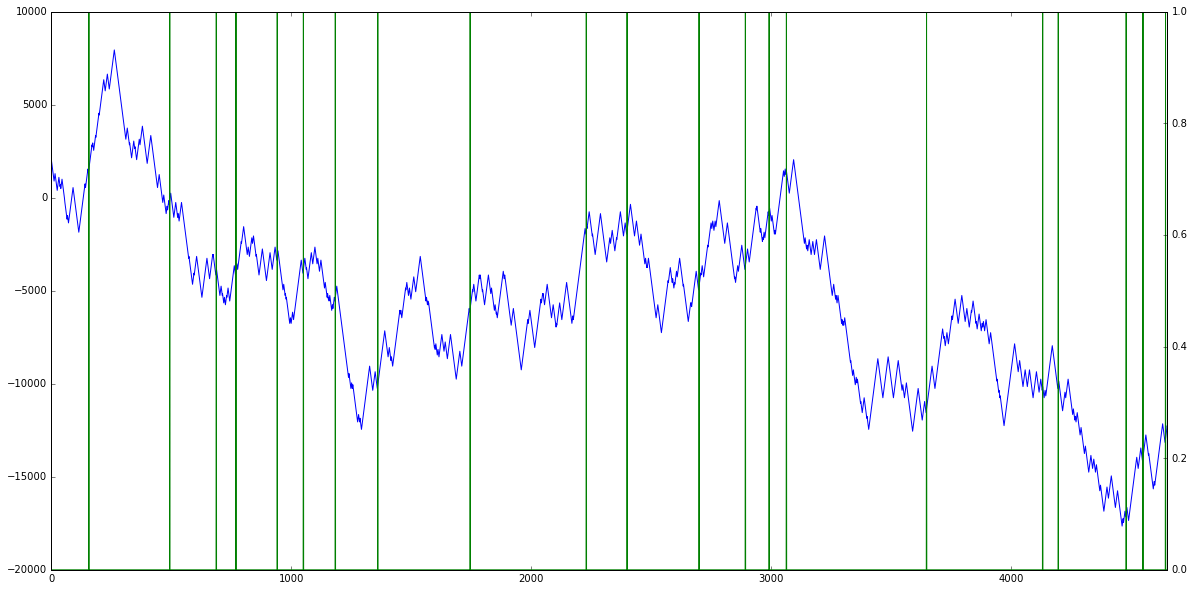

In [43]:
figsize(20,10)
renko_df.close[:].plot()
#renko_df.low[:].plot()

(renko_df.renko_fall_price_up_move_count==2).plot(secondary_y=True)

#(renko_df.renko_fall_price_up_move_count==2).plot(secondary_y=True)

#renko_df.small_double_bottom.plot(secondary_y=True)
#renko_df.small_double_top.plot(secondary_y=True)

In [57]:
strategyname = 'strategy_180113'
d, info = matlab.loaddata('../../mat/'+strategyname+'.mat')

In [58]:
df = pd.DataFrame()
df['close'] = d.exo

In [59]:
#renko_df.index = renko_df.date

df = df.join(renko_df.set_index('date')[['peak','fall','flat','trend_up','trend_down','small_double_bottom',
                                        'small_double_top','up_trend_correction', 'down_trend_correction']])
df = df.fillna(False)

df = df.join(renko_df.set_index('date')[['renko_peak_price_move','renko_fall_price_move']])
df = df.join(renko_df.set_index('date')[['up_count', 'down_count', 'renko_peak_price_up_move_count',
                                           'renko_peak_price_down_move_count', 'renko_peak_price_same_move_count',
                                           'renko_fall_price_up_move_count', 'renko_fall_price_down_move_count',
                                           'renko_fall_price_same_move_count']])
#df = df.join(renko_df.fall, how='right')
#df = df.join(renko_df.flat, how='right')
#df = df.join(renko_df.trend_up)
#df = df.join(renko_df.trend_down)
#df = df.join(renko_df.small_double_bottom)
#df = df.join(renko_df.small_double_top)
#df = df.join(renko_df.up_trend_correction)
#df = df.join(renko_df.down_trend_correction)

#df = df.join(renko_peak_price_move)
#df = df.join(renko_fall_price_move)

In [65]:
signals_df[signals_df.peak == True]

,exo,fut_price,volume,close,peak,fall,flat,trend_up,trend_down,small_double_bottom,...,renko_peak_price_move,renko_fall_price_move,up_count,down_count,renko_peak_price_up_move_count,renko_peak_price_down_move_count,renko_peak_price_same_move_count,renko_fall_price_up_move_count,renko_fall_price_down_move_count,renko_fall_price_same_move_count
2011-02-14,-1730.0,84780.0,170054,-1730.0,True,False,False,False,False,False,...,NaN,NaN,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-05-05,4180.0,94740.0,479048,4180.0,True,False,False,False,False,False,...,up,NaN,0.0,2.0,1.0,0.0,0.0,NaN,NaN,NaN
2011-05-05,4180.0,94740.0,479048,4180.0,True,False,False,False,False,False,...,up,NaN,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-05-05,4180.0,94740.0,479048,4180.0,True,False,False,False,False,False,...,up,NaN,0.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-05-05,4180.0,94740.0,479048,4180.0,True,False,False,False,False,False,...,NaN,NaN,0.0,2.0,1.0,0.0,0.0,NaN,NaN,NaN
2011-05-05,4180.0,94740.0,479048,4180.0,True,False,False,False,False,False,...,NaN,NaN,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-05-05,4180.0,94740.0,479048,4180.0,True,False,False,False,False,False,...,NaN,NaN,0.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-05-05,4180.0,94740.0,479048,4180.0,True,False,False,False,False,False,...,NaN,NaN,0.0,2.0,1.0,0.0,0.0,NaN,NaN,NaN
2011-05-05,4180.0,94740.0,479048,4180.0,True,False,False,False,False,False,...,NaN,NaN,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-05-05,4180.0,94740.0,479048,4180.0,True,False,False,False,False,False,...,NaN,NaN,0.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN


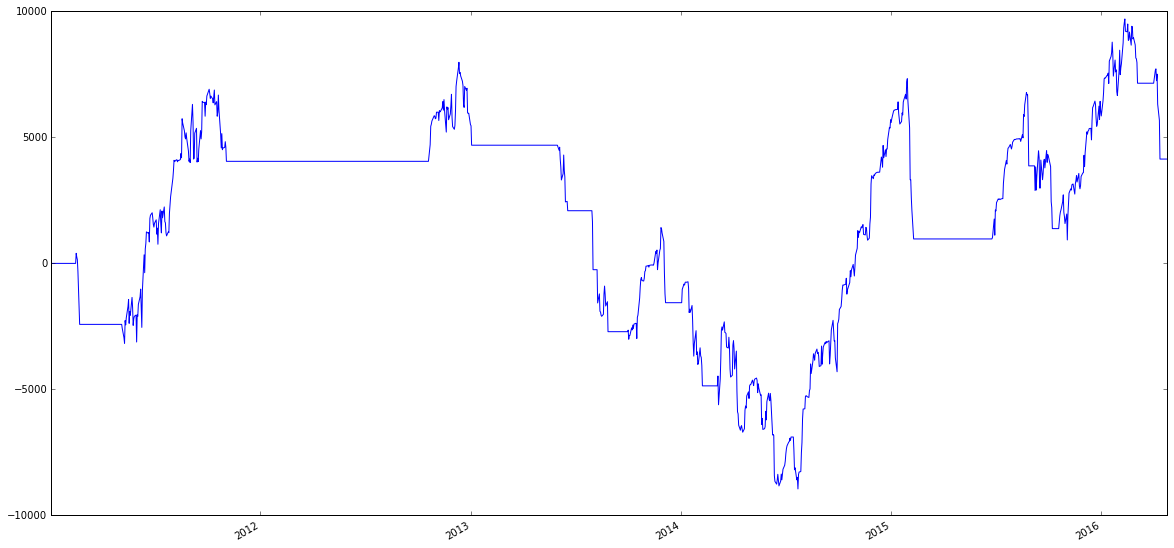

In [63]:
signals_df = d.join(df)

trailing_stop = signals_df.exo.rolling(30).median().shift(1)

short_entry = (signals_df.peak == True)
short_exit = (signals_df.fall == True)
#short_exit = CrossDown(temp_df.exo, trailing_stop)

direction = -1
pl, inposition = backtester.backtest(signals_df, short_entry, short_exit, direction)
equity, stats = backtester.stats(pl, inposition)

equity.plot()

In [204]:
signals_df.columns

Index(['exo', 'fut_price', 'volume', 'close', 'peak', 'fall', 'flat',
       'trend_up', 'trend_down', 'small_double_bottom', 'small_double_top',
       'up_trend_correction', 'down_trend_correction', 'renko_peak_price_move',
       'renko_fall_price_move', 'up_count', 'down_count',
       'renko_peak_price_up_move_count', 'renko_peak_price_down_move_count',
       'renko_peak_price_same_move_count', 'renko_fall_price_up_move_count',
       'renko_fall_price_down_move_count', 'renko_fall_price_same_move_count'],
      dtype='object')

In [238]:
d.join(renko_df, on=renko_df['date'])

KeyError: "['2011-01-04T03:00:00.000000000+0300' '2011-01-21T03:00:00.000000000+0300'\n '2011-01-27T03:00:00.000000000+0300' '2011-01-31T03:00:00.000000000+0300'\n '2011-01-31T03:00:00.000000000+0300' '2011-02-04T03:00:00.000000000+0300'\n '2011-02-14T03:00:00.000000000+0300' '2011-02-21T03:00:00.000000000+0300'\n '2011-02-21T03:00:00.000000000+0300' '2011-03-01T03:00:00.000000000+0300'\n '2011-03-07T03:00:00.000000000+0300' '2011-03-22T03:00:00.000000000+0300'\n '2011-03-31T04:00:00.000000000+0400' '2011-04-06T04:00:00.000000000+0400'\n '2011-04-20T04:00:00.000000000+0400' '2011-04-29T04:00:00.000000000+0400'\n '2011-05-03T04:00:00.000000000+0400' '2011-05-05T04:00:00.000000000+0400'\n '2011-05-05T04:00:00.000000000+0400' '2011-05-05T04:00:00.000000000+0400'\n '2011-05-23T04:00:00.000000000+0400' '2011-05-25T04:00:00.000000000+0400'\n '2011-06-06T04:00:00.000000000+0400' '2011-06-09T04:00:00.000000000+0400'\n '2011-06-10T04:00:00.000000000+0400' '2011-06-13T04:00:00.000000000+0400'\n '2011-06-23T04:00:00.000000000+0400' '2011-07-07T04:00:00.000000000+0400'\n '2011-07-11T04:00:00.000000000+0400' '2011-07-22T04:00:00.000000000+0400'\n '2011-07-28T04:00:00.000000000+0400' '2011-08-02T04:00:00.000000000+0400'\n '2011-08-18T04:00:00.000000000+0400' '2011-08-18T04:00:00.000000000+0400'\n '2011-08-29T04:00:00.000000000+0400' '2011-09-05T04:00:00.000000000+0400'\n '2011-09-07T04:00:00.000000000+0400' '2011-09-07T04:00:00.000000000+0400'\n '2011-09-09T04:00:00.000000000+0400' '2011-09-13T04:00:00.000000000+0400'\n '2011-09-19T04:00:00.000000000+0400' '2011-09-22T04:00:00.000000000+0400'\n '2011-10-24T04:00:00.000000000+0400' '2011-11-03T04:00:00.000000000+0400'\n '2011-11-15T04:00:00.000000000+0400' '2011-11-23T04:00:00.000000000+0400'\n '2011-11-30T04:00:00.000000000+0400' '2011-12-08T04:00:00.000000000+0400'\n '2011-12-15T04:00:00.000000000+0400' '2011-12-27T04:00:00.000000000+0400'\n '2012-01-02T04:00:00.000000000+0400' '2012-01-03T04:00:00.000000000+0400'\n '2012-01-12T04:00:00.000000000+0400' '2012-01-24T04:00:00.000000000+0400'\n '2012-02-02T04:00:00.000000000+0400' '2012-02-14T04:00:00.000000000+0400'\n '2012-02-20T04:00:00.000000000+0400' '2012-02-24T04:00:00.000000000+0400'\n '2012-03-06T04:00:00.000000000+0400' '2012-03-09T04:00:00.000000000+0400'\n '2012-03-29T04:00:00.000000000+0400' '2012-04-19T04:00:00.000000000+0400'\n '2012-05-01T04:00:00.000000000+0400' '2012-05-03T04:00:00.000000000+0400'\n '2012-05-04T04:00:00.000000000+0400' '2012-05-18T04:00:00.000000000+0400'\n '2012-05-30T04:00:00.000000000+0400' '2012-06-21T04:00:00.000000000+0400'\n '2012-06-21T04:00:00.000000000+0400' '2012-06-29T04:00:00.000000000+0400'\n '2012-07-03T04:00:00.000000000+0400' '2012-07-06T04:00:00.000000000+0400'\n '2012-07-09T04:00:00.000000000+0400' '2012-07-17T04:00:00.000000000+0400'\n '2012-07-19T04:00:00.000000000+0400' '2012-07-23T04:00:00.000000000+0400'\n '2012-08-06T04:00:00.000000000+0400' '2012-08-07T04:00:00.000000000+0400'\n '2012-08-16T04:00:00.000000000+0400' '2012-09-13T04:00:00.000000000+0400'\n '2012-09-19T04:00:00.000000000+0400' '2012-10-19T04:00:00.000000000+0400'\n '2012-10-23T04:00:00.000000000+0400' '2012-11-15T04:00:00.000000000+0400'\n '2012-11-19T04:00:00.000000000+0400' '2012-11-27T04:00:00.000000000+0400'\n '2012-12-10T04:00:00.000000000+0400' '2012-12-19T04:00:00.000000000+0400'\n '2013-01-02T04:00:00.000000000+0400' '2013-01-10T04:00:00.000000000+0400'\n '2013-01-22T04:00:00.000000000+0400' '2013-02-08T04:00:00.000000000+0400'\n '2013-02-12T04:00:00.000000000+0400' '2013-02-15T04:00:00.000000000+0400'\n '2013-03-01T04:00:00.000000000+0400' '2013-03-26T04:00:00.000000000+0400'\n '2013-04-03T04:00:00.000000000+0400' '2013-04-05T04:00:00.000000000+0400'\n '2013-04-10T04:00:00.000000000+0400' '2013-04-11T04:00:00.000000000+0400'\n '2013-04-15T04:00:00.000000000+0400' '2013-04-25T04:00:00.000000000+0400'\n '2013-04-25T04:00:00.000000000+0400' '2013-05-01T04:00:00.000000000+0400'\n '2013-05-02T04:00:00.000000000+0400' '2013-05-03T04:00:00.000000000+0400'\n '2013-05-20T04:00:00.000000000+0400' '2013-05-22T04:00:00.000000000+0400'\n '2013-05-31T04:00:00.000000000+0400' '2013-06-07T04:00:00.000000000+0400'\n '2013-06-18T04:00:00.000000000+0400' '2013-06-20T04:00:00.000000000+0400'\n '2013-07-02T04:00:00.000000000+0400' '2013-07-05T04:00:00.000000000+0400'\n '2013-07-10T04:00:00.000000000+0400' '2013-07-18T04:00:00.000000000+0400'\n '2013-07-24T04:00:00.000000000+0400' '2013-07-30T04:00:00.000000000+0400'\n '2013-08-01T04:00:00.000000000+0400' '2013-08-01T04:00:00.000000000+0400'\n '2013-08-06T04:00:00.000000000+0400' '2013-08-08T04:00:00.000000000+0400'\n '2013-08-09T04:00:00.000000000+0400' '2013-08-27T04:00:00.000000000+0400'\n '2013-09-17T04:00:00.000000000+0400' '2013-09-30T04:00:00.000000000+0400'\n '2013-10-21T04:00:00.000000000+0400' '2013-10-30T04:00:00.000000000+0400'\n '2013-11-27T04:00:00.000000000+0400' '2013-12-03T04:00:00.000000000+0400'\n '2013-12-05T04:00:00.000000000+0400' '2013-12-27T04:00:00.000000000+0400'\n '2013-12-31T04:00:00.000000000+0400' '2014-01-02T04:00:00.000000000+0400'\n '2014-01-22T04:00:00.000000000+0400' '2014-02-07T04:00:00.000000000+0400'\n '2014-02-18T04:00:00.000000000+0400' '2014-03-03T04:00:00.000000000+0400'\n '2014-03-05T04:00:00.000000000+0400' '2014-03-05T04:00:00.000000000+0400'\n '2014-03-11T04:00:00.000000000+0400' '2014-03-12T04:00:00.000000000+0400'\n '2014-03-27T04:00:00.000000000+0400' '2014-04-02T04:00:00.000000000+0400'\n '2014-04-04T04:00:00.000000000+0400' '2014-04-09T04:00:00.000000000+0400'\n '2014-04-30T04:00:00.000000000+0400' '2014-05-21T04:00:00.000000000+0400'\n '2014-06-02T04:00:00.000000000+0400' '2014-06-09T04:00:00.000000000+0400'\n '2014-06-12T04:00:00.000000000+0400' '2014-07-03T04:00:00.000000000+0400'\n '2014-07-21T04:00:00.000000000+0400' '2014-07-29T04:00:00.000000000+0400'\n '2014-07-31T04:00:00.000000000+0400' '2014-08-12T04:00:00.000000000+0400'\n '2014-08-14T04:00:00.000000000+0400' '2014-09-19T04:00:00.000000000+0400'\n '2014-09-26T04:00:00.000000000+0400' '2014-09-30T04:00:00.000000000+0400'\n '2014-10-08T04:00:00.000000000+0400' '2014-10-27T03:00:00.000000000+0300'\n '2014-11-04T03:00:00.000000000+0300' '2014-11-27T03:00:00.000000000+0300'\n '2014-12-15T03:00:00.000000000+0300' '2014-12-29T03:00:00.000000000+0300'\n '2015-01-13T03:00:00.000000000+0300' '2015-02-02T03:00:00.000000000+0300'\n '2015-02-03T03:00:00.000000000+0300' '2015-02-03T03:00:00.000000000+0300'\n '2015-02-04T03:00:00.000000000+0300' '2015-02-04T03:00:00.000000000+0300'\n '2015-02-06T03:00:00.000000000+0300' '2015-02-09T03:00:00.000000000+0300'\n '2015-02-10T03:00:00.000000000+0300' '2015-02-13T03:00:00.000000000+0300'\n '2015-02-23T03:00:00.000000000+0300' '2015-03-10T03:00:00.000000000+0300'\n '2015-03-18T03:00:00.000000000+0300' '2015-03-25T03:00:00.000000000+0300'\n '2015-04-06T03:00:00.000000000+0300' '2015-04-14T03:00:00.000000000+0300'\n '2015-04-15T03:00:00.000000000+0300' '2015-04-30T03:00:00.000000000+0300'\n '2015-05-12T03:00:00.000000000+0300' '2015-05-19T03:00:00.000000000+0300'\n '2015-06-25T03:00:00.000000000+0300' '2015-07-01T03:00:00.000000000+0300'\n '2015-07-15T03:00:00.000000000+0300' '2015-07-22T03:00:00.000000000+0300'\n '2015-08-19T03:00:00.000000000+0300' '2015-08-28T03:00:00.000000000+0300'\n '2015-08-28T03:00:00.000000000+0300' '2015-08-31T03:00:00.000000000+0300'\n '2015-09-01T03:00:00.000000000+0300' '2015-09-07T03:00:00.000000000+0300'\n '2015-10-06T03:00:00.000000000+0300' '2015-10-08T03:00:00.000000000+0300'\n '2015-10-12T03:00:00.000000000+0300' '2015-10-19T03:00:00.000000000+0300'\n '2015-10-26T03:00:00.000000000+0300' '2015-11-03T03:00:00.000000000+0300'\n '2015-11-05T03:00:00.000000000+0300' '2015-11-19T03:00:00.000000000+0300'\n '2015-12-07T03:00:00.000000000+0300' '2015-12-18T03:00:00.000000000+0300'\n '2016-01-06T03:00:00.000000000+0300' '2016-01-19T03:00:00.000000000+0300'\n '2016-01-28T03:00:00.000000000+0300' '2016-02-02T03:00:00.000000000+0300'\n '2016-02-10T03:00:00.000000000+0300' '2016-03-01T03:00:00.000000000+0300'\n '2016-03-04T03:00:00.000000000+0300' '2016-03-07T03:00:00.000000000+0300'\n '2016-03-17T03:00:00.000000000+0300' '2016-03-24T03:00:00.000000000+0300'\n '2016-04-01T03:00:00.000000000+0300' '2016-04-11T03:00:00.000000000+0300'\n '2016-04-12T03:00:00.000000000+0300'] not in index"

In [228]:
d.join(df)

,exo,fut_price,volume,close,peak,fall,flat,trend_up,trend_down,small_double_bottom,...,renko_peak_price_move,renko_fall_price_move,up_count,down_count,renko_peak_price_up_move_count,renko_peak_price_down_move_count,renko_peak_price_same_move_count,renko_fall_price_up_move_count,renko_fall_price_down_move_count,renko_fall_price_same_move_count
2011-01-03,2100.0,91930.0,116931,2100.0,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-04,870.0,89240.0,307960,870.0,False,False,False,False,False,False,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-05,1330.0,90200.0,306083,1330.0,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-06,580.0,88600.0,262856,580.0,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-07,370.0,87730.0,275676,370.0,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-10,430.0,89060.0,264161,430.0,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-11,820.0,90690.0,223593,820.0,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-12,1200.0,91690.0,234220,1200.0,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-13,620.0,91070.0,205224,620.0,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-14,720.0,91360.0,196619,720.0,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [221]:
t.count(1)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().